# Project Overview:

URL: "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"

The Kaggle dataset above shows multiple chest X-rays of patients who either had pneumonia, COVID-19, or no illness at all. 

The hope of this project is to create several different Neural Networks:

1. *Simple Convulutional Neural Networks*
2. *Complex Convulutional Neural Networks* 
3. *ResNet Neural Network*
4. *Use Data Augmentation to see different results* 

and use TensorFlow/Keras to properly and accurately predict whether an X-ray image has COVID-19, pneumonia, or nothing at all. 

Some things to note on this project are:


1.   We are using an already pre-processed dataset. The datasets are broken into test and train folders
> Within those folders we have the images already classified as either Normal, COVID-19, or Pneumonia


2.   In order to not bog down Google Colab, we will be running a small amount of neural networks. To properly optimize the model, we could play with various variables (learning rate, epoch sizes, batch sizes)...but for our purposes here, we'll be running small sizes so the program runs quickly. Note that the ResNet model is pre-trained, and due to its size, it takes a massive amount of time to run. 


## Import Modules

First thing to do is to import all the modules


In [ ]:
import tensorflow as tf
from tensorflow import argmax
from tensorflow import expand_dims
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet import ResNet50

from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



## Import Datasets

Now we import the data we'll be working with

In [ ]:
#all modules brought in, now download dataset from Kaggle and create neural network
url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle



/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
ls

Covid19-dataset/  kaggle.json


In [ ]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

We have our modules, and we have our dataset.

We're ready now to start our data processing and modeling...

## Data Pre-Processing

First thing we want to do is create a training and a test iterator/generator

In [ ]:
def iterator(data_generator, directory, class_mode, color_mode, batch_size, target_size):
  iterator = data_generator.flow_from_directory(directory,
                                                class_mode = class_mode, 
                                                color_mode = color_mode,
                                                batch_size = batch_size,
                                                target_size = target_size,
                                                seed = 500)
  return iterator

In [ ]:
input_data = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
training_iterator = iterator(
    data_generator = input_data,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/train', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))

training_iterator

Found 251 images belonging to 3 classes.


In [ ]:
test_iterator = iterator(
    data_generator = input_data,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/test', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))

test_iterator

Found 66 images belonging to 3 classes.


Great. We have both of our iterators, lets see what the image shapes are like.

In [ ]:
def get_training_shape(iterator):
  sample_batch_input, sample_batch_labels = iterator.next()
  shape = sample_batch_input.shape
  # there are 4 numbers output here
  # first number = the number of images per batch
  # second and third number = the size of the images
  # fourth number = the color mode of the images
  return shape[1:]



In [ ]:
input_shape = get_training_shape(training_iterator)
input_shape

(224, 224, 1)

## Creating Our Various Models

We've got the training and the test iterators (and necessary information on each)...we can start creating our various models now

### Simple CNN Model

For this model, we will create a simple convulutional neural network. The idea behind this is it not having too many layers, and being able to see the results at each layer. Small parameters, small runtime, and hopefully see some decent results.

#### Build our Model Class

In [ ]:
def create_simple_cnn_model(input_shape, learning_rate):
  """
  A CNN with 2 layers
  """

  #instantiate the model
  model = Sequential()

  #create the input layer
  model.add(layers.Input(shape = input_shape))

  #add the Convulutional Layer
  model.add(layers.Conv2D(
      4, 
      5, 
      strides = 2,  
      activation='relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (3,3), 
      strides = (3,3),
      ))
  
  #add second convultional and pooling layer
  model.add(layers.Conv2D(
      8,
      3,
      strides = 1,
      activation = 'relu'
  ))

  model.add(layers.MaxPooling2D(
      pool_size = (2, 2),
      strides = (2, 2)
  ))

  # now flatten layers so can pass through a Dense layer
  model.add(layers.Flatten())

  # now add our Dense layers 
  # first our hidden layer
  model.add(layers.Dense(16, activation = 'relu'))

  model.add(layers.Dense(8, activation = 'relu'))

  # now our output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  #now compile
  model.compile(
      loss = losses.CategoricalCrossentropy(),
      metrics = [
                 metrics.CategoricalAccuracy(),
                 metrics.AUC()
      ],
      optimizer = optimizers.Adam(learning_rate = learning_rate)
  )

  return model

In [ ]:
#call out model here, and pick a learning rate
#after multiple iterations, 0.01 learning rate was a rate that worked nicely
simple_cnn_model = create_simple_cnn_model(input_shape, 0.01)

We've created our model with our selected parameters, so let's just see the models summary and see the amount of parameters we're working with


In [ ]:
#lets see the summary of the simple CNN model
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 4)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2312)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                3

#### Fit The Model

We've created our model above, now we can run it through our function to fit it.

In [ ]:
def fit_model(model, training_iterator, test_iterator, batch_size, epoch_size):

  #get our early stopping variable here
  early_stop = EarlyStopping(
      monitor = 'loss',
      patience = 6
  )
  
  #now get the history object of the model
  print("Training the model. This may take a while...")
  history = model.fit(
      training_iterator, 
      steps_per_epoch = training_iterator.samples/batch_size, 
      epochs = epoch_size, 
      verbose = 1,
      callbacks = [early_stop],
      validation_data = test_iterator, 
      validation_steps = test_iterator.samples/batch_size
  )

  return history

In [ ]:
#Constant variables we can come back and change or optimize later
epochs = 100
batch_size = 25

In [ ]:
#now fit the model and save the variable so can run some analysis later
simple_cnn_fit = fit_model(simple_cnn_model, training_iterator, test_iterator, batch_size, epochs)

Training the model. This may take a while...
Epoch 1/100
10/10 [==============================] - 62s 6s/step - loss: 1.0783 - categorical_accuracy: 0.4273 - auc_1: 0.5709 - val_loss: 1.0183 - val_categorical_accuracy: 0.3667 - val_auc_1: 0.6300
Epoch 2/100
10/10 [==============================] - 32s 3s/step - loss: 0.8614 - categorical_accuracy: 0.5091 - auc_1: 0.7607 - val_loss: 0.7027 - val_categorical_accuracy: 0.6667 - val_auc_1: 0.8894
Epoch 3/100
10/10 [==============================] - 18s 2s/step - loss: 0.7712 - categorical_accuracy: 0.6727 - auc_1: 0.8380 - val_loss: 0.9421 - val_categorical_accuracy: 0.5667 - val_auc_1: 0.7239
Epoch 4/100
10/10 [==============================] - 9s 891ms/step - loss: 0.5125 - categorical_accuracy: 0.7921 - auc_1: 0.9248 - val_loss: 0.5763 - val_categorical_accuracy: 0.7667 - val_auc_1: 0.9006
Epoch 5/100
10/10 [==============================] - 10s 994ms/step - loss: 0.5546 - categorical_accuracy: 0.7909 - auc_1: 0.9104 - val_loss: 0.6380 

Perfect! We've fit our model, and our early stop worked, stopping our program from continuing because it realized the convergence of the accuracy.

#### Visualize the Results of the Model

Let's see our model and how accurate it was. 

We are going to be plotting accuracy versus epoch, and AUC versus epoch

In [ ]:
def visualize_accuracy(model):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure(figsize = (14,8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(model.history['categorical_accuracy'])
    ax1.plot(model.history['val_categorical_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # plotting auc and validation auc over epochs
    keys = list(model.history.keys())
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(model.history[keys[2]])
    ax2.plot(model.history[keys[-1]])
    ax2.set_title('model auc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

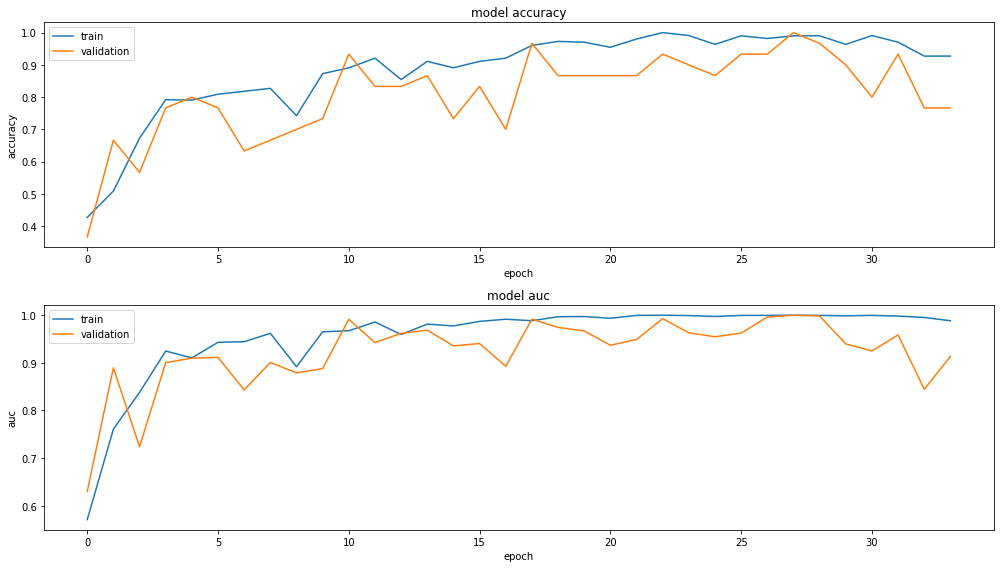

In [ ]:
visualize_accuracy(simple_cnn_fit)

#### Create Statistical Reports

We've seen the loss metrics visually, lets also see the classification report and the confusion matrix, and compare how the model does on the actual test set.

In [ ]:
def class_report(not_fit_model, test_iterator):
  test_steps_per_epoch = np.math.ceil(test_iterator.samples / test_iterator.batch_size)
  predictions = not_fit_model.predict(test_iterator, steps=test_steps_per_epoch)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_iterator.classes
  class_labels = list(test_iterator.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)

  print("Our classification report is: ")
  print(report)
  return report

In [ ]:
def con_matrix(fit_model, test_iterator):
  test_steps_per_epoch = np.math.ceil(test_iterator.samples / test_iterator.batch_size)
  predictions = fit_model.model.predict(test_iterator, steps=test_steps_per_epoch)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_iterator.classes
  class_labels = list(test_iterator.class_indices.keys())
  report = classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = confusion_matrix(true_classes, predicted_classes)

  print("Our confusion matrix is: ")
  sns.heatmap(cm, annot=True, cmap='Blues')
  plt.show()
  return cm


In [ ]:
simple_cnn_class_report = class_report(simple_cnn_model, test_iterator)

7/7 [==============================] - 2s 252ms/step
Our classification report is: 
                 precision    recall  f1-score   support

          Covid       0.41      0.35      0.38        26
         Normal       0.23      0.15      0.18        20
Viral Pneumonia       0.29      0.45      0.35        20

       accuracy                           0.32        66
      macro avg       0.31      0.32      0.30        66
   weighted avg       0.32      0.32      0.31        66



7/7 [==============================] - 2s 248ms/step
Our confusion matrix is: 


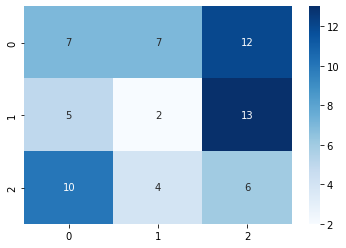

In [ ]:
simple_cnn_conf_matrix = con_matrix(simple_cnn_fit, test_iterator)

#### Plot Keras Model Breakdown

Keras has a very neat feature built in that actually shows the breakdown of the model. It cleanly shows the layers, the direction the data travels, the input and output size, and finally the output all in graph form

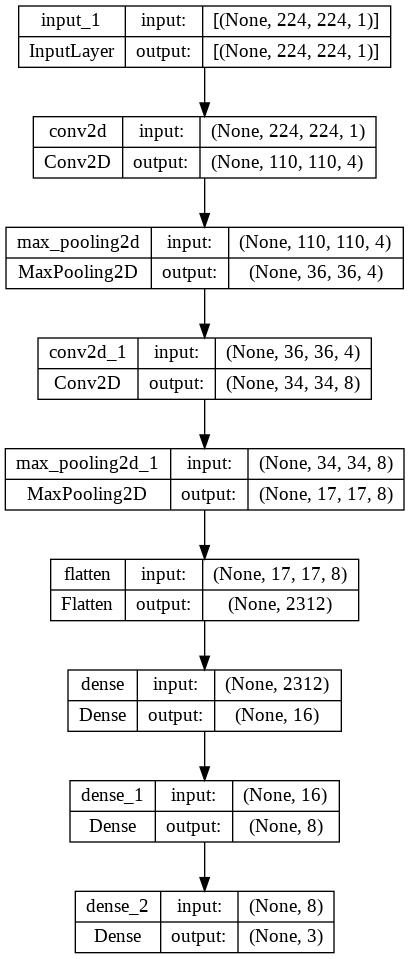

In [ ]:
#show our plot_model and then save that file so we can put in the presentation
plot_model(simple_cnn_model, to_file='simple_cnn_model.png', show_shapes=True)

### Complex CNN Model

#### Build Model Class

In [ ]:
def create_complex_cnn_model(input_shape, learning_rate):

  """
  a CNN with 5 layers
  """

  #instantiate the model
  model = Sequential()

  #create the input layer
  model.add(layers.Input(shape = input_shape))

  #add the Convulutional Layer
  model.add(layers.Conv2D(
      32, 
      3, 
      strides = 2,
      padding = "same",  
      activation = 'relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (2,2), 
      strides = (2,2),
      ))
  
   #add the Convulutional Layer
  model.add(layers.Conv2D(
      64, 
      3, 
      strides = 2,
      padding = "same",  
      activation = 'relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (2, 2), 
      strides = (2, 2),
      ))
  
   #add the Convulutional Layer
  model.add(layers.Conv2D(
      128, 
      3, 
      strides = 2,
      padding = "same",  
      activation = 'relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (2, 2), 
      strides = (2, 2),
      ))
  #add the Convulutional Layer
  model.add(layers.Conv2D(
      256, 
      3, 
      strides = 2,
      padding = "same",  
      activation = 'relu'))

  #add the Pooling Layer
  model.add(layers.MaxPooling2D(
      pool_size = (2, 2), 
      strides = (2, 2),
      ))

  # now flatten layers so can pass through a Dense layer
  model.add(layers.Flatten())

  # now add our Dense layers 
  # first our hidden layer
  model.add(layers.Dense(128, activation = 'relu'))

  #add our second dense layer
  # model.add(layers.Dense(64, activation = 'relu'))

  # now our output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  #now compile
  model.compile(
      loss = losses.CategoricalCrossentropy(),
      metrics = [
                 metrics.CategoricalAccuracy(),
                 metrics.AUC()
      ],
      optimizer = optimizers.Adam(learning_rate = learning_rate)
  )

  return model

In [ ]:
complex_cnn_model = create_complex_cnn_model(input_shape, 0.1)
complex_cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 112, 112, 32)      320       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 3, 3, 128)      

#### Fit The Model

In [ ]:
complex_cnn_fit = fit_model(complex_cnn_model, 
                           training_iterator, 
                           test_iterator, 
                           batch_size, 
                           epochs)

Training the model. This may take a while...
Epoch 1/100
10/10 [==============================] - 8s 778ms/step - loss: 1.0832 - categorical_accuracy: 0.4636 - auc_11: 0.5818 - val_loss: 1.1154 - val_categorical_accuracy: 0.3333 - val_auc_11: 0.5650
Epoch 2/100
10/10 [==============================] - 7s 723ms/step - loss: 1.0756 - categorical_accuracy: 0.4364 - auc_11: 0.5867 - val_loss: 1.1285 - val_categorical_accuracy: 0.4000 - val_auc_11: 0.5569
Epoch 3/100
10/10 [==============================] - 7s 701ms/step - loss: 1.0672 - categorical_accuracy: 0.4364 - auc_11: 0.6062 - val_loss: 1.1018 - val_categorical_accuracy: 0.3333 - val_auc_11: 0.6156
Epoch 4/100
10/10 [==============================] - 7s 676ms/step - loss: 1.0614 - categorical_accuracy: 0.4364 - auc_11: 0.6159 - val_loss: 1.1148 - val_categorical_accuracy: 0.2333 - val_auc_11: 0.5300
Epoch 5/100
10/10 [==============================] - 6s 654ms/step - loss: 1.1517 - categorical_accuracy: 0.3861 - auc_11: 0.5812 - val

#### Vizualize the Results of the Model

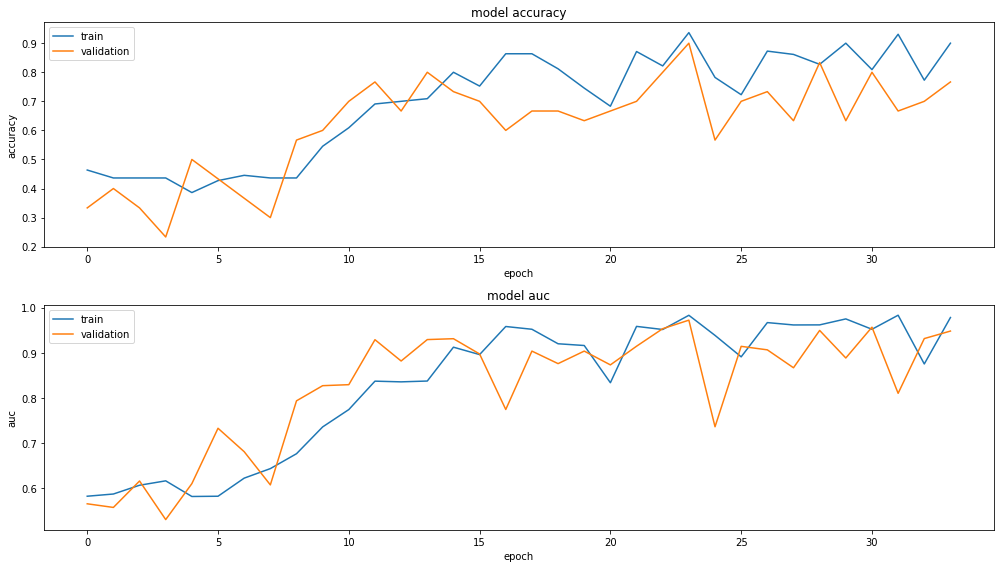

In [ ]:
visualize_accuracy(complex_cnn_fit)

#### Create Statistical Reports

In [ ]:
complex_cnn_class_report = class_report(complex_cnn_model, test_iterator)

7/7 [==============================] - 2s 289ms/step
Our classification report is: 
                 precision    recall  f1-score   support

          Covid       0.28      0.27      0.27        26
         Normal       0.20      0.15      0.17        20
Viral Pneumonia       0.35      0.45      0.39        20

       accuracy                           0.29        66
      macro avg       0.28      0.29      0.28        66
   weighted avg       0.28      0.29      0.28        66



7/7 [==============================] - 2s 271ms/step
Our confusion matrix is: 


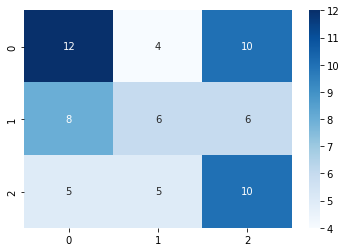

In [ ]:
complex_cnn_conf_matrix = con_matrix(complex_cnn_fit, test_iterator)

#### Plot Keras Model Breakdown

In [ ]:
plot_model(complex_cnn_model, to_file='complex-cnn-for-covid-19.png', show_shapes=True)

### ResNet Model

#### Build the Model

In [ ]:
def create_resnet_model():

  """
  a pre-trained 152 Conv2D layered model.

  Since the model is pretrained, you don't need to do all the additions of the Conv2D layers.

  INSTEAD -- you need to:
    1. Instantiate the class
    2. Get the model inputs
    3. Get the model outputs
    4. Add a dropout
    5. Then do your standard optimizer, compile, and then you can fit
  """
  #get the model
  model = ResNet50(weights = 'imagenet', 
                      include_top = False)
  
  #create our pooling average
  global_avg_pooling = layers.GlobalAveragePooling2D()(model.output)

  #get the dropout
  dropout = layers.Dropout(rate = 0.5)(global_avg_pooling) #added dropout

  #get our outputs
  output = layers.Dense(3, activation = 'softmax')(dropout)

  #assemble our model
  model = Model(inputs = model.input, outputs = output)

  model.compile(loss = 'categorical_crossentropy', 
                optimizer = optimizers.Adam(learning_rate=1e-5, 
                                            beta_1=0.9, 
                                            beta_2=0.999, 
                                            epsilon=1e-07), 
                metrics = [
                 metrics.CategoricalAccuracy(),
                 metrics.AUC()
      ])
  
  return model

In [ ]:
resnet_model = create_resnet_model()

94765736/94765736 [==============================] - 3s 0us/step


#### Fit the Model

In [ ]:
resnet_fit_model = resnet_model.fit(train_iterator, 
                                    epochs = 30, 
                                    validation_data = test_iterator, 
                                    verbose = 1, 
                                    callbacks = EarlyStopping(monitor = 'loss', 
                                                              patience = 6)
                                    )

Epoch 1/30
32/32 [==============================] - 177s 5s/step - loss: 1.1776 - categorical_accuracy: 0.4661 - auc_12: 0.6686 - val_loss: 1.3073 - val_categorical_accuracy: 0.3939 - val_auc_12: 0.5401
Epoch 2/30
32/32 [==============================] - 167s 5s/step - loss: 0.6337 - categorical_accuracy: 0.7291 - auc_12: 0.8934 - val_loss: 1.9760 - val_categorical_accuracy: 0.3939 - val_auc_12: 0.7047
Epoch 3/30
32/32 [==============================] - 186s 6s/step - loss: 0.4004 - categorical_accuracy: 0.8606 - auc_12: 0.9623 - val_loss: 4.3462 - val_categorical_accuracy: 0.3939 - val_auc_12: 0.5469
Epoch 4/30
32/32 [==============================] - 180s 6s/step - loss: 0.2848 - categorical_accuracy: 0.9044 - auc_12: 0.9864 - val_loss: 6.1916 - val_categorical_accuracy: 0.3939 - val_auc_12: 0.5455
Epoch 5/30
32/32 [==============================] - 178s 6s/step - loss: 0.1892 - categorical_accuracy: 0.9363 - auc_12: 0.9942 - val_loss: 7.3925 - val_categorical_accuracy: 0.3939 - val_

#### Visualize the Results of the Model

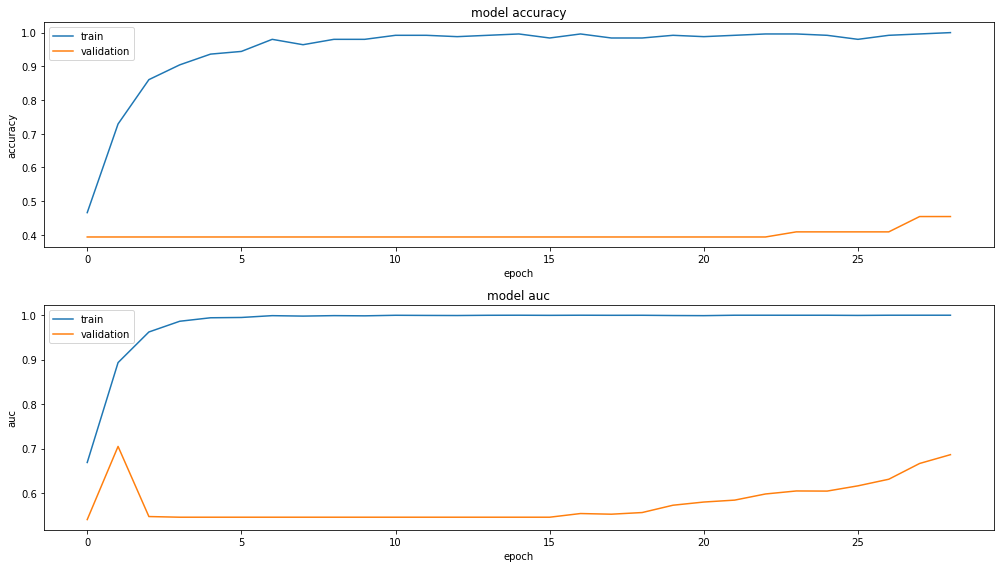

In [ ]:
visualize_accuracy(resnet_fit_model)

#### Create Statistical Reports

In [ ]:
all_batches = []
count = 1
for batch in tqdm(test_iterator):
    all_batches.append(batch)
    count = count + 1
    if count == 30:
        break

31it [00:10,  3.01it/s]


In [ ]:
resnet_all_y_hats = []
resnet_all_y = []
for X, y in all_batches:
    y_hat = resnet_fit_model.predict(X)
    y_hat = np.argmax(y_hat, 1)
    resnet_all_y_hats.extend(list(y_hat))
    resnet_all_y.extend(list(np.argmax(y, 1)))

1/1 [==============================] - 1s 1s/step


In [ ]:
print(classification_report(resnet_all_y, resnet_all_y_hats))

              precision    recall  f1-score   support

           0       0.72      1.00      0.83        91
           1       1.00      0.04      0.08        74
           2       0.53      0.78      0.63        73

    accuracy                           0.63       238
   macro avg       0.75      0.61      0.51       238
weighted avg       0.75      0.63      0.54       238



NOTE -- We are not plotting the output here as we clearly know the architecture of the ResNet50 model...we can google it and see that its a 50 layer Conv2D model (and also presented in the class presentation more details about it)

## Data Augmentation!
We're using Data Augmentation to tune our model. NOTE - we tuned other hyperparameters through trial and error, optimizing things like learning rate and batch_size




In Deep Learning, there are multiple ways of tweaking models and optimizing them:
  1. Tweak the hyperparameters
    - this means tweaking things like the hidden layers, batch size, epochs, and/or learning rate
  2. Tweak the layers
    - Add of subtract Conv2D layers with different activation functions and/or padding variables
  3. The one we will talk a bit about here -- Data Augmentation

In data augmentation, rather than changing the models parameters, we actually manipulate the input data. Since we are working with images, the changes that we do can be found in the arguments of *ImageDataGenerator* - but on a high level, we are going to be rotating the photos, randomly flipping some photos horizontally and/or vertically, and/or shift the center of the image in any direction.

The reason for the data augmentation is to ensure the model doesnt just train on the same photos in continuous order and develop any sort of bias - so by augmenting the images, we hope the model will learn better.

Here, we're going to run the data augmentation on the complex CNN model and see the results from there (not doing it on the ResNet as the ResNet model fitting takes an enormously long time).

### Augment the Data

In [ ]:
augmented_input_data = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True)  # randomly flip images


In [ ]:
aug_training_iterator = iterator(
    data_generator = augmented_input_data,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/train', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))
aug_training_iterator

Found 251 images belonging to 3 classes.


In [ ]:
aug_test_iterator = iterator(
    data_generator = augmented_input_data,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/test', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))
aug_training_iterator

Found 66 images belonging to 3 classes.


### Build the Model

In [ ]:
aug_complex_cnn_model = create_complex_cnn_model(input_shape, 0.1)

In [ ]:
aug_complex_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 128)       

### Fit the Model

In [ ]:
aug_complex_cnn_fit = fit_model(aug_complex_cnn_model, aug_training_iterator, aug_test_iterator, batch_size, epochs)

Training the model. This may take a while...
Epoch 1/100
10/10 [==============================] - 9s 826ms/step - loss: 332755.0938 - categorical_accuracy: 0.3465 - auc_2: 0.5333 - val_loss: 35.1792 - val_categorical_accuracy: 0.3667 - val_auc_2: 0.5344
Epoch 2/100
10/10 [==============================] - 7s 691ms/step - loss: 16.1903 - categorical_accuracy: 0.3564 - auc_2: 0.4832 - val_loss: 1.7079 - val_categorical_accuracy: 0.3667 - val_auc_2: 0.5319
Epoch 3/100
10/10 [==============================] - 7s 769ms/step - loss: 19.1442 - categorical_accuracy: 0.4091 - auc_2: 0.5688 - val_loss: 1.1414 - val_categorical_accuracy: 0.2333 - val_auc_2: 0.4500
Epoch 4/100
10/10 [==============================] - 8s 754ms/step - loss: 11.4231 - categorical_accuracy: 0.3636 - auc_2: 0.5093 - val_loss: 1.9737 - val_categorical_accuracy: 0.2667 - val_auc_2: 0.4333
Epoch 5/100
10/10 [==============================] - 8s 747ms/step - loss: 688.0914 - categorical_accuracy: 0.2727 - auc_2: 0.4795 - v

### Visualize the Results of the Model

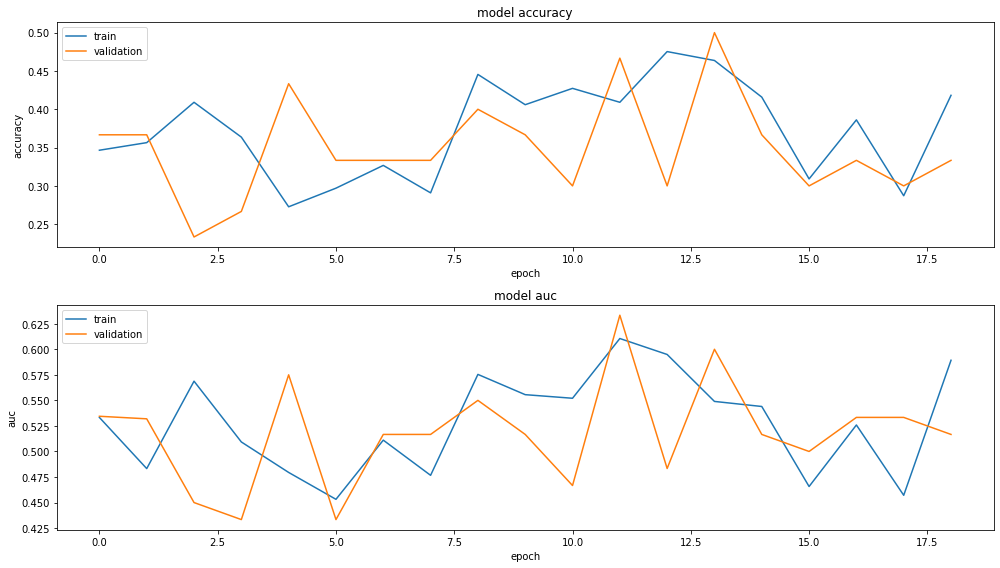

In [ ]:
visualize_accuracy(aug_complex_cnn_fit)

### Create Statistical Reports

7/7 [==============================] - 3s 328ms/step
Our classification report is: 
                 precision    recall  f1-score   support

          Covid       0.39      1.00      0.57        26
         Normal       0.00      0.00      0.00        20
Viral Pneumonia       0.00      0.00      0.00        20

       accuracy                           0.39        66
      macro avg       0.13      0.33      0.19        66
   weighted avg       0.16      0.39      0.22        66



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 2s 294ms/step
Our confusion matrix is: 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


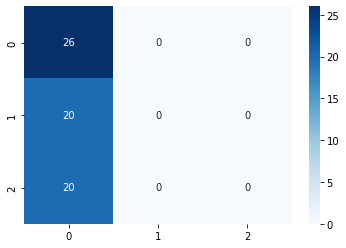

In [ ]:
aug_simple_cnn_class_report = class_report(aug_complex_cnn_model, aug_test_iterator)
aug_our_conf_matrix = con_matrix(aug_complex_cnn_fit, aug_test_iterator)

# Overall Results

Overall Results: 

1.   *Simple CNN* - **50% accuracy**
2.   *Complex CNN* - **29% accuracy**
3.   *ResNet50 Model* - **63% accuracy**

Model Tuning:
4.   *Augmented Data on Complex CNN* - **39% accuracy**


Key take aways:

1.   More complex is not always better! The Simple 2-Layer CNN model produced better than both the Complex 4-Layer CNN model and the Augmented Data model.
2.   The pre-trained model performed the best, which was also proven in research papers. The fact that they are already optimized for various images makes a big difference in performance
  - Important to note that the pre-trained model took SIGNIFICANTLY longer to train. Where as the CNN's I made took only a few minutes, the ResNet took over 1.5 hours and caused my Collab notebook to crash.
3.   Data augmentation is a common model tuning technique to improve results in CNN's, and we saw in our model that it increased the accuracy of the regular complex model by 10%. It would be nice to test this technique on other models and see the type of effect this has.
4.   Lastly - ways to get better results from our very poor models:
  - **Tweak hyperparameters** - Things we could change are the `learning rate`, the `number of epochs`, the `batch sizes`, and the `various filters` and `strides`. In order to get a better result, we would look to optimize each parameter, and let the algo run and produce a better result. Due to time/computer restraints, this is something that we will leave as is for the time being
  - **Get more Data** - Due to only have 200 images total, the amount of data isnt enough to produce results that would be able to be put into production. The more data, the more reliable the model and algo, and the less error. Working with this small amount of data was nice for Google Collab as it didnt cause many cluster failures (except when running the enormous ResNet model 
  - **Optimize CNN Layers** - We obviously only created 2- and 4- layer CNN's and we can clearly see they were not optimized. With a deeper understanding of CNN infrastructure, more compute resources, and more time, the layers could be optimized such that it accurately makes predictions. Things like `pool_size`, `strides`, `kernels`, `filters`, etc...could all be optimized in a better fashion than we did.





